In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
import string
import re
from matplotlib import pyplot as plt

### Collecting Stop words from StopWords list 

In [4]:
generic=pd.read_csv('StopWords_GenericLong.txt', sep=" ",header=None)
curr=pd.read_csv('StopWords_Currencies.txt', sep="|", encoding='latin1',header=None)
geo=pd.read_csv('StopWords_Geographic.txt',sep="|",header=None)
names=pd.read_csv('StopWords_Names.txt',sep="|",header=None)
gen=pd.read_csv('StopWords_Generic.txt',header=None)
datNnum=pd.read_csv('StopWords_DatesandNumbers.txt',sep='|',header=None)
audit=pd.read_csv('StopWords_Auditor.txt',header=None)

def strp(i):
    return str(i).strip().lower()
# StopWords
s_w=[]
for i in [generic,curr,geo,names,gen,datNnum,audit]:
    s_w=s_w+list(map(strp,i[0]))    

### Positive and Negative words list

In [5]:
pos=pd.read_csv('positive-words (1).txt', header=None)
# Positive words which are not in given StopWords list
positive=[k for k in list(pos[0]) if k not in s_w]

neg=pd.read_csv('negative-words (1).txt', header=None, encoding='latin1')
# Negative words which are not in given StopWords list
negative=[k for k in neg[0] if k not in s_w]

## Defining Functions and Classes

In [223]:
def scraping(i,url_id):    
    url=f'{i}'
    try:
        page=requests.get(url, headers={'User-Agent':'XY'})
        html=BeautifulSoup(page.text,'lxml')
        title=html.find('h1',class_='entry-title').text
        article=""
        for i in html.find('div',class_='td-post-content').find_all('p'):
            a="".join(i.text)
            article=article+" "+a
        article=title+" "+article
        with open(f'{url_id}.txt', 'w',encoding="utf-8") as f:
            f.write(article)
            f.close()
        return article,WordPunctTokenizer().tokenize(article.lower())
    except:
        pass

In [224]:
class scores:
    
    def __init__(self, cl_token_gvn_stw):
        self.cl_token_gvn_stw = cl_token_gvn_stw
        
    def positive_s(self):
        posi=[1 for j in self.cl_token_gvn_stw if j in positive]
        positive_score=sum(posi)
        return positive_score
        
    def negative_s(self):
        nega=[1 for j in self.cl_token_gvn_stw if j in negative]
        negative_score=sum(nega)
        return negative_score             
        
    def polarity_s(self,positive_score,negative_score):
        polarity=(positive_score - negative_score)/((positive_score+negative_score)+0.000001)
        return round(polarity,2)
        
    def subjectivity_s(self,positive_score,negative_score):
        subjectivity=(positive_score+negative_score)/(len(self.cl_token_gvn_stw)+0.000001)
        return round(subjectivity,3)

In [152]:
class text_analytics:
    
    def __init__(self, article, cl_token):
        self.article=article
        self.cl_token=cl_token
        
    def word_c(self):
        return len(self.cl_token)
    
    def avg_word_l(self):
        l=0
        for i in cl_token:
            l=l+len(i)
        return round(l/len(self.cl_token),1)   
    
    def pronoun_c(self):
        pronounRegex = re.compile(r'\b(I|we|my|ours|(?-i:us))\b',re.I)
        return len(pronounRegex.findall(self.article))
    
    def avg_sentence(self):
        sent=sent_tokenize(self.article)
        return round(len(self.cl_token)/len(sent))
    
    def syllable_c(self):
        sylb=0
        cmp=0
        for i in cl_token:
            c=0
            for j in i:
                if j in ['a','e','i','o','u']:
                    sylb=sylb+1
                    c=c+1
            try:        
                if i[-2:] in ['ed','es']:
                    sylb=sylb-1
                    c=c-1
            except:
                pass
            if c>2:
                cmp=cmp+1
        
        return cmp, round(sylb/len(self.cl_token),1)


## Creating DataFrame in Output format

In [225]:
Output=pd.read_excel('Output Data Structure.xlsx')

In [226]:
Output.head()

,URL_ID,URL,POSITIVE SCORE,NEGATIVE SCORE,POLARITY SCORE,SUBJECTIVITY SCORE,AVG SENTENCE LENGTH,PERCENTAGE OF COMPLEX WORDS,FOG INDEX,AVG NUMBER OF WORDS PER SENTENCE,COMPLEX WORD COUNT,WORD COUNT,SYLLABLE PER WORD,PERSONAL PRONOUNS,AVG WORD LENGTH
0,37.0,https://insights.blackcoffer.com/ai-in-healthc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,38.0,https://insights.blackcoffer.com/what-if-the-c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,39.0,https://insights.blackcoffer.com/what-jobs-wil...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40.0,https://insights.blackcoffer.com/will-machine-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41.0,https://insights.blackcoffer.com/will-ai-repla...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Performing Data Extraction and Textual Analysis on each link

In [227]:
for n,i in enumerate(Output['URL']):
    try:
        article,token=scraping(i,Output.loc[n,'URL_ID'])
    # removing stop words given in the StopWords list
        cl_token_gvn_stw=[w for w in token if w not in s_w]
    
    # Creating Object for class scores-
        score=scores(cl_token_gvn_stw)
    
        Positive_score=score.positive_s()
    
        Negative_score=score.negative_s()
    
        Polarity_score=score.polarity_s(Positive_score,Negative_score)
    
        Subjectivity_score=score.subjectivity_s(Positive_score,Negative_score)
    
    
        # cleaning text using nltk stopwords package and string punctuation
        cl_token=[w for w in token if w not in stopwords.words('English') and i not in string.punctuation]
    
        # Creating Object for class text_analytics-
        ta=text_analytics(article,cl_token)
    
        Word_count=ta.word_c()
    
        Avg_word_length=ta.avg_word_l()
    
        Personal_pronouns=ta.pronoun_c()
    
        Avg_words_per_sentence=ta.avg_sentence()

        Complex_words , Syllables_per_word = ta.syllable_c()
    
        # Analysis of Readability
    
        Avg_sentence_length=ta.avg_sentence()
    
        Percentage_complex_words= round((Complex_words / Word_count)*100,2)
    
        Fog_index= round(0.4*(Avg_sentence_length + Percentage_complex_words),2)
        
        # updating the values in output sheet
    
        Output.at[n,'POSITIVE SCORE']=Positive_score
        Output.at[n,'NEGATIVE SCORE']=Negative_score
        Output.at[n,'POLARITY SCORE']=Polarity_score
        Output.at[n,'SUBJECTIVITY SCORE']=Subjectivity_score
        Output.at[n,'AVG SENTENCE LENGTH']=Avg_sentence_length
        Output.at[n,'PERCENTAGE OF COMPLEX WORDS']=Percentage_complex_words
        Output.at[n,'FOG INDEX']=Fog_index
        Output.at[n,'AVG NUMBER OF WORDS PER SENTENCE']=Avg_words_per_sentence
        Output.at[n,'COMPLEX WORD COUNT']=Complex_words
        Output.at[n,'WORD COUNT']=Word_count
        Output.at[n,'SYLLABLE PER WORD']=Syllables_per_word
        Output.at[n,'PERSONAL PRONOUNS']=Personal_pronouns
        Output.at[n,'AVG WORD LENGTH']=Avg_word_length
    
    except:
        pass

In [234]:
Output.head()

,URL_ID,URL,POSITIVE SCORE,NEGATIVE SCORE,POLARITY SCORE,SUBJECTIVITY SCORE,AVG SENTENCE LENGTH,PERCENTAGE OF COMPLEX WORDS,FOG INDEX,AVG NUMBER OF WORDS PER SENTENCE,COMPLEX WORD COUNT,WORD COUNT,SYLLABLE PER WORD,PERSONAL PRONOUNS,AVG WORD LENGTH
0,37.0,https://insights.blackcoffer.com/ai-in-healthc...,66.0,34.0,0.32,0.083,19.0,41.22,24.09,19.0,575.0,1395.0,2.2,1.0,6.0
1,38.0,https://insights.blackcoffer.com/what-if-the-c...,58.0,37.0,0.22,0.122,12.0,28.17,16.07,12.0,278.0,987.0,1.8,7.0,5.1
2,39.0,https://insights.blackcoffer.com/what-jobs-wil...,64.0,35.0,0.29,0.096,14.0,41.80,22.32,14.0,505.0,1208.0,2.2,3.0,6.1
3,40.0,https://insights.blackcoffer.com/will-machine-...,60.0,27.0,0.38,0.110,12.0,31.18,17.27,12.0,333.0,1068.0,2.0,17.0,5.4
4,41.0,https://insights.blackcoffer.com/will-ai-repla...,58.0,25.0,0.40,0.083,16.0,31.12,18.85,16.0,379.0,1218.0,1.9,16.0,5.5


In [235]:
Output.to_excel('D:\Internships\Assignments\Textual_Analysis/Output.xlsx', index=False)

In [3]:
df = pd.read_excel('Output.xlsx')

In [4]:
df.head()

,URL_ID,URL,POSITIVE SCORE,NEGATIVE SCORE,POLARITY SCORE,SUBJECTIVITY SCORE,AVG SENTENCE LENGTH,PERCENTAGE OF COMPLEX WORDS,FOG INDEX,AVG NUMBER OF WORDS PER SENTENCE,COMPLEX WORD COUNT,WORD COUNT,SYLLABLE PER WORD,PERSONAL PRONOUNS,AVG WORD LENGTH
0,37,https://insights.blackcoffer.com/ai-in-healthc...,66.0,34.0,0.32,0.083,19.0,41.22,24.09,19.0,575.0,1395.0,2.2,1.0,6.0
1,38,https://insights.blackcoffer.com/what-if-the-c...,58.0,37.0,0.22,0.122,12.0,28.17,16.07,12.0,278.0,987.0,1.8,7.0,5.1
2,39,https://insights.blackcoffer.com/what-jobs-wil...,64.0,35.0,0.29,0.096,14.0,41.80,22.32,14.0,505.0,1208.0,2.2,3.0,6.1
3,40,https://insights.blackcoffer.com/will-machine-...,60.0,27.0,0.38,0.110,12.0,31.18,17.27,12.0,333.0,1068.0,2.0,17.0,5.4
4,41,https://insights.blackcoffer.com/will-ai-repla...,58.0,25.0,0.40,0.083,16.0,31.12,18.85,16.0,379.0,1218.0,1.9,16.0,5.5


In [5]:
import seaborn as sns

<AxesSubplot:xlabel='POLARITY SCORE', ylabel='Count'>

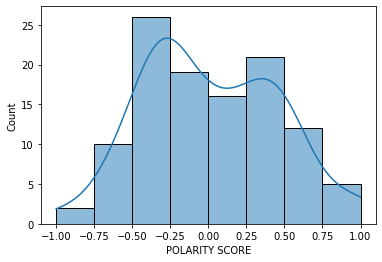

In [6]:
sns.histplot(df['POLARITY SCORE'], kde=True)

C:\Users\prath\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WORD COUNT'>

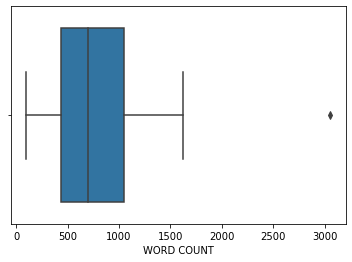

In [7]:
sns.boxplot(df['WORD COUNT'])